In [16]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

# Q4 Blackjack game

In [23]:
cards = np.array(list(range(1,11)) + [10,10,10])

In [24]:
# Initializing player's card
def player_initialize():
    value = 0 
    usable_ace = 0
    while(value<12):
        card=np.random.choice(cards)
        if(card==1):
            usable_ace = 1
        value+=card
    return value,usable_ace

## a) First visit MC

In [25]:
def simulate():
    # draw player's initial cards
    player_sum, usable_ace = player_initialize()
    states = []
    #draw dealer's initial cards
    dealer_sum = 0
    show = np.random.choice(cards)
    dealer_sum = show + np.random.choice(cards)
    
    if(player_sum>=12):
        states.append((player_sum, show, usable_ace))

    #Check for natural
    if(player_sum==21):
        if(dealer_sum==21):
            return states, 0 
        else:
            return states, 1
    elif(dealer_sum==21):
        return states,-1
    else:
    #Player's turn
        while(1):
            # Turn
            draw = np.random.choice(cards)
            if(draw == 1):
                if(player_sum<=10):
                    value = player_sum + 11
                    usable_ace = 1 
                else:
                    value = player_sum + 1
            else:
                value = player_sum + draw
            # If usable ace is available then convert the ace to 1

            if(value>=22 and usable_ace == 1):
                value = player_sum - 10
                usable_ace = 0

            # Check final value
            if(value>21):
                return states,-1
            elif(value==21):
                states.append((value,show,usable_ace))
                return states,1
            elif(value==20):
                states.append((value,show,usable_ace))
                break
            else:
                if(value>=12):
                    states.append((value,show,usable_ace))
                player_sum = value
    #Dealer's turn
    #Keep hitting until sum is either more than 17 or dealer loses

        while(1):
            draw = np.random.choice(cards)
            if(draw==1):
                if(dealer_sum<=10):
                    dealer_sum += 11
                    usable_ace = 1 
                else:
                    dealer_sum+=1
            else:
                dealer_sum+=draw

            if(dealer_sum==21):
                return states,-1
            elif(dealer_sum>21):
                if(usable_ace==1):
                    dealer_sum-=10
                    usable_ace=0
                else:
                    return states,1
            elif(dealer_sum>=17):
                break
    # Check which sum is closer 21
    if(dealer_sum<player_sum):
        return states,1
    elif(player_sum<dealer_sum):
        return states,-1
    else:
        return states,0    

In [26]:
# First visit monte-carlo
eps = 10000
state_counts = np.ones((10,10,2))
state_values = np.zeros((10,10,2))
for ep in tqdm(range(eps)):
    states,reward = simulate()
    states.reverse() 
    for i,state in enumerate(states):
        x,y,z = state
        x = x-12
        y = y-1
        if(state not in states[i+1:]):
            state_values[x,y,z] = (state_values[x,y,z]*state_counts[x,y,z] + reward)/(state_counts[x,y,z]+1)
            state_counts[x,y,z]+=1


## Plot for 10000 episodes

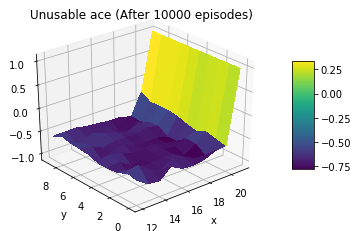

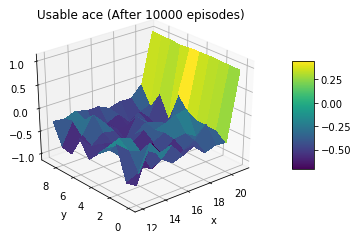

In [27]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

for i in range(2):
    un_usable = state_values[:,:,i]

    X, Y = np.meshgrid(np.arange(12, 12+un_usable.shape[0]), np.arange(un_usable.shape[1]),indexing='ij')


    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, un_usable, rstride=1, cstride=1, cmap='viridis', linewidth=0, antialiased=False)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlim(-1.1,1.1)
    ax.view_init(azim=-130)

    fig.colorbar(surf, shrink=0.5, aspect=5)
    if(i==0):
        plt.title('Unusable ace (After 10000 episodes)')
    else: 
        plt.title('Usable ace (After 10000 episodes)')
    plt.show()

## Plot for 500000 episodes

In [28]:
# First visit monte-carlo
eps = 500000
state_counts = np.ones((10,10,2))
state_values = np.zeros((10,10,2))
for ep in tqdm(range(eps)):
    states,reward = simulate()
    states.reverse() 
    for i,state in enumerate(states):
        x,y,z = state
        x = x-12
        y = y-1
        if(state not in states[i+1:]):
            state_values[x,y,z] = (state_values[x,y,z]*state_counts[x,y,z] + reward)/(state_counts[x,y,z]+1)
            state_counts[x,y,z]+=1

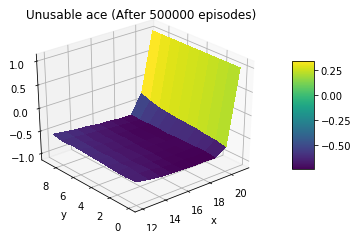

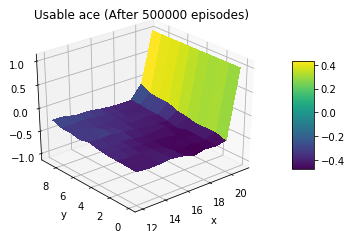

In [29]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

for i in range(2):
    un_usable = state_values[:,:,i]

    X, Y = np.meshgrid(np.arange(12,12+un_usable.shape[0]), np.arange(un_usable.shape[1]),indexing='ij')


    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, un_usable, rstride=1, cstride=1, cmap='viridis', linewidth=0, antialiased=False)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlim(-1.1,1.1)
    ax.view_init(azim=-130)

    fig.colorbar(surf, shrink=0.5, aspect=5)
    if(i==0):
        plt.title('Unusable ace (After 500000 episodes)')
    else: 
        plt.title('Usable ace (After 500000 episodes)')
    plt.show()

## b) MC with exploring starts

In [4]:
#Simulating with policy pi

#action 0 -> stick
#action 1 -> hit

def simulate(pi):
    # draw player's initial cards
    player_sum,usable_ace = player_initialize()
    state_actions = []
    #draw dealer's initial cards
    show = np.random.choice(cards)
    dealer_sum = show + np.random.choice(cards)
    
    #Check for natural
    if(player_sum==21):
        if(dealer_sum==21):
            return [], 0
        else:
            return [], 1
    elif(dealer_sum==21):
        return [],-1
    else:
    #Player's turn
        while(1):
            # check policy
            if(pi[player_sum-12][show-1][usable_ace]==1):
                # Action taken -> Hit
                state_actions.append((player_sum,show,usable_ace,1))
                draw = np.random.choice(cards)
                player_sum+=draw  
                # If usable ace is available then convert the ace to 1
                if(player_sum>=22 and usable_ace == 1):
                    player_sum -= 10
                    usable_ace = 0

                # Check for win or lose 
                if(player_sum>21):
                    return state_actions,-1
                elif(player_sum==21):
                    return state_actions,1
                
            else:
                #Action taken -> Stick
                state_actions.append((player_sum,show,usable_ace,0))
                break
    
    #Dealer's turn
    #Keep hitting until sum is either more than 17 or dealer loses
        usable_ace = 0 
        while(1):
            draw = np.random.choice(cards)
            if(draw==1):
                #If possible convert the ace to 11
                if(dealer_sum<=10):
                    dealer_sum += 11
                    usable_ace = 1 
                else:
                    dealer_sum+=1
            else:
                dealer_sum+=draw
            if(dealer_sum==21):
                return state_actions,-1
            # If usable ace is available then convert the ace to 1
            elif(dealer_sum>21):
                if(usable_ace==1):
                    dealer_sum-=10
                    usable_ace=0
                else:
                    return state_actions,1
            elif(dealer_sum>=17):
                break
    # Check which sum is closer 21
        if(dealer_sum<player_sum):
            return state_actions,1
        elif(player_sum<dealer_sum):
            return state_actions,-1
        else:
            return state_actions,0    

In [5]:
# Monte carlo with exploring starts
eps = 500000
# Count of different state action pair
state_action_counts = np.ones((10,10,2,2))
# Value of different state action pairs
q_s_a = np.zeros((10,10,2,2))
# Starting policy
pi = np.ones((10,10,2))
pi[8:,:,:]=0
for ep in tqdm(range(eps)):
    state_action,reward = simulate(pi)
    state_action.reverse() 
    for i,s_a in enumerate(state_action):
        x,y,z,action = s_a
        x = x-12
        y = y-1
        if(s_a not in state_action[i+1:]):
            q_s_a[x,y,z,action] = (q_s_a[x,y,z,action]*state_action_counts[x,y,z,action] + reward)/(state_action_counts[x,y,z,action]+1)
            state_action_counts[x,y,z,action]+=1
        #Update the policy
        pi[x,y,z] = np.argmax(q_s_a[x,y,z,:])

In [6]:
v_star = np.max(q_s_a,axis=3)

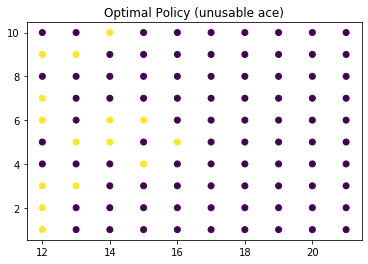

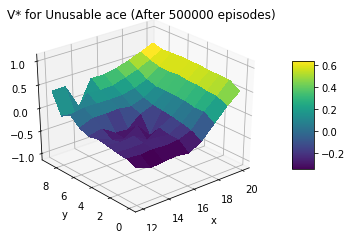

In [14]:
X,Y = np.meshgrid(np.arange(12,22),np.arange(1,11),indexing='ij')
plt.scatter(np.ravel(X),np.ravel(Y),c = np.ravel(pi[:,:,0]) )
plt.title('Optimal Policy (unusable ace)')
plt.show()
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

un_usable = v_star[:9,:,0]

X, Y = np.meshgrid(np.arange(12,12 + un_usable.shape[0]), np.arange(un_usable.shape[1]),indexing='ij')


fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, un_usable, rstride=1, cstride=1, cmap='viridis', linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlim(-1.1,1.1)
ax.view_init(azim=-130)

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('V* for Unusable ace (After 500000 episodes)')

plt.show()

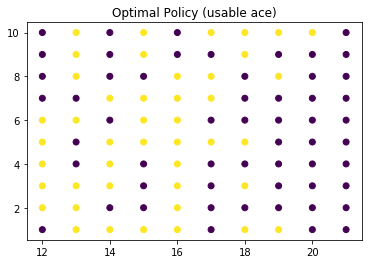

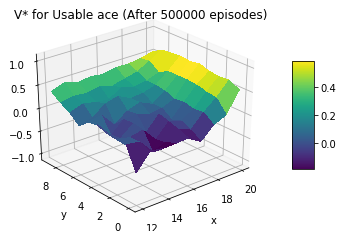

In [15]:
X,Y = np.meshgrid(np.arange(12,22),np.arange(1,11),indexing='ij')
plt.scatter(np.ravel(X),np.ravel(Y),c = np.ravel(pi[:,:,1]) )
plt.title('Optimal Policy (usable ace)')
plt.show()

usable = v_star[:9,:,1]

X, Y = np.meshgrid(np.arange(12,12+usable.shape[0]), np.arange(usable.shape[1]),indexing='ij')


fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, usable, rstride=1, cstride=1, cmap='viridis', linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlim(-1.1,1.1)
ax.view_init(azim=-130)

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('V* for Usable ace (After 500000 episodes)')

plt.show()

## c) Off policy prediction

In [11]:
#Simulate using behaviour policy b
def simulate(b,t):
    player_sum = 13
    show = 2
    usable_ace = 1
    state_actions = []
    #Initializing ratio of target and behaviour policies
    rho = 1 
    #Player's turn
    while(1):
        # check policy
        num = np.random.uniform(0,1)
        if(num > b[player_sum-12][show-1][usable_ace][1]):
            # Action taken -> Hit
            state_actions.append((player_sum,show,usable_ace,1))
            rho*= t[player_sum-12][show-1][usable_ace][1]/b[player_sum-12][show-1][usable_ace][1] 
            draw = np.random.choice(cards)
            player_sum+=draw  
            if(player_sum>=22 and usable_ace == 1):
                player_sum -= 10
                usable_ace = 0

            # Check for win or lose 
            if(player_sum>21):
                return state_actions,rho,-1
            elif(player_sum==21):
                return state_actions,rho,1

        else:
            #Action taken -> Stick
            rho*= t[player_sum-12][show-1][usable_ace][0]/b[player_sum-12][show-1][usable_ace][0]
            state_actions.append((player_sum,show,usable_ace,0))
            break
            
    usable_ace = 0 
    dealer_sum = 0
    # Dealer's turn
    while(1):
        draw = np.random.choice(cards)
        if(draw==1):
            if(dealer_sum<=10):
                dealer_sum += 11
                usable_ace = 1 
            else:
                dealer_sum+=1
        else:
            dealer_sum+=draw
        if(dealer_sum==21):
            return state_actions,rho,-1
        elif(dealer_sum>21):
            if(usable_ace==1):
                dealer_sum-=10
                usable_ace=0
            else:
                return state_actions,rho,1
        elif(dealer_sum>=17):
            break
            
    if(dealer_sum<player_sum):
        return state_actions,rho,1
    elif(player_sum<dealer_sum):
        return state_actions,rho,-1
    return state_actions,rho,0

In [87]:
behaviour = np.zeros((10,10,2,2)) # Player sum x show card x usable ace x probability of action (stick <- 0 , hit <- 1)
target = np.ones((10,10,2,2))
behaviour.fill(0.5) # Equal probability for hit and stick
target[8:,:,:,1] = 0 #Don't hit for player value >= 20
STATE_VAL = -.27726
RUNS = 100
EPS = 10000
ms_ordinary = np.zeros(EPS)
ms_weighted = np.zeros(EPS)
for i in tqdm(range(RUNS)):
    ordinary = 0
    weighted = 0
    rho_sum = 0
    ord_est = np.zeros(EPS)
    wei_est = np.zeros(EPS)
    for j in range(EPS):
        state_actions,rho,reward = simulate(behaviour,target)
        estimate = rho*reward
        ordinary = (ordinary*j + estimate)/(j+1)
#         print(ordinary)
        if(rho_sum+rho!=0):
            weighted = np.divide((weighted*rho_sum + estimate),(rho_sum+rho))
        ord_est[j] = ordinary
        wei_est[j] = weighted
        rho_sum+=rho
    ms_ordinary+= np.power(ord_est-STATE_VAL,2)
    ms_weighted+= np.power(wei_est-STATE_VAL,2)
    


ms_ordinary = ms_ordinary/RUNS
ms_weighted = ms_weighted/RUNS
 

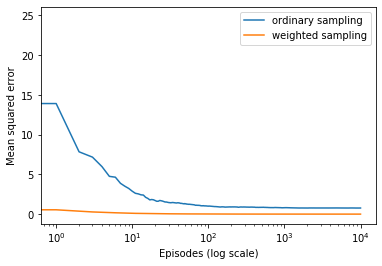

In [95]:
plt.plot(ms_ordinary,label='ordinary sampling')
plt.plot(ms_weighted,label='weighted sampling')
plt.xlabel('Episodes (log scale)')
plt.ylabel('Mean squared error')
plt.legend()
plt.xscale('log')

# Q6 Random Walk

## a) State values vs Episodes

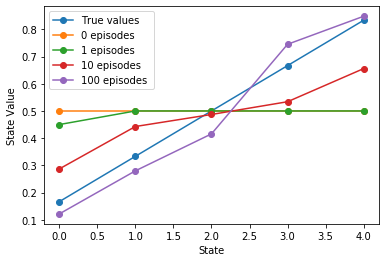

In [91]:
# TEMPORAL DIFFERENCE
state_values = np.zeros(7)
state_values[1:6] = .5
true_values = np.array([1/6,2/6,3/6,4/6,5/6])
alpha = .1
gamma = 1
EPS = 100
ep_num = [0,1,10,100]
alphas = [.1,.15,.05]
rmse = {}
plt.plot(true_values,label='True values',marker='o')
for alpha in alphas:
    errors = np.zeros(EPS+1)
    for ep in tqdm(range(EPS+1)):
        state = 3   #Start at middle state
        if(ep in ep_num and alpha==.1):
            plt.plot(state_values[1:6],label = str(ep) +' episodes ',marker='o')
        while(1):
            if(np.random.binomial(1,.5)< 0.5): #move left
                state_values[state] += alpha*(0 + gamma*state_values[state-1] - state_values[state])
                state -= 1
                if(state==0):
                    break
            else: #move right
                if(state+1==6):
                    state_values[state] += alpha*(1 + gamma*state_values[state+1] - state_values[state])
                    break
                else:
                    state_values[state] += alpha*(0 + gamma*state_values[state+1] - state_values[state])
                    state += 1
        errors[ep] = np.sqrt(np.sum(np.power(state_values[1:6]-true_values,2))/5)
    rmse[alpha] = errors
plt.xlabel('State')
plt.ylabel('State Value')
plt.legend()         
plt.show()

## b) RMSE Comparison TD vs MC

In [92]:
# TEMPORAL DIFFERENCE
state_values = np.zeros(7)
true_values = np.array([1/6,2/6,3/6,4/6,5/6])
alpha = .1
gamma = 1
EPS = 100
RUNS = 100
ep_num = [0,1,10,100]
alphas = [.1,.15,.05]
rmse = {}

for alpha in alphas:
    errors = np.zeros(EPS+1)
    for run in tqdm(range(RUNS)):
        state_values[1:6] = .5
        for ep in (range(EPS+1)):
            state = 3   #Start at middle state
            while(1):
                if(np.random.binomial(1,.5)< 0.5): #move left
                    state_values[state] += alpha*(0 + gamma*state_values[state-1] - state_values[state])
                    state -= 1
                    if(state==0):
                        break
                else: #move right
                    if(state+1==6):
                        state_values[state] += alpha*(1 + gamma*state_values[state+1] - state_values[state])
                        break
                    else:
                        state_values[state] += alpha*(0 + gamma*state_values[state+1] - state_values[state])
                        state += 1
            errors[ep] += np.sqrt(np.sum(np.power(state_values[1:6]-true_values,2))/5)
    
    rmse[alpha] = errors/RUNS

In [93]:
# MONTE CARLO WITH CONSTANT STEP SIZE

state_values = np.zeros(7)
true_values = np.array([1/6,2/6,3/6,4/6,5/6])
alpha = .1
gamma = 1
EPS = 100
RUNS = 100
ep_num = [0,1,10,100]
alphas = [.01,.02,.03,.04]
rmse_mc = {}

for alpha in alphas:
    errors = np.zeros(EPS+1)
    for run in tqdm(range(RUNS)):
        state_values[1:6] = .5
        for ep in (range(EPS+1)):
            state = 3   #Start at middle state
            states=[]
            states.append(state)
            reward = 0
            while(1):
                if(np.random.binomial(1,.5)< 0.5): #move left
                    state -= 1
                    if(state==0):
                        break
                    else:
                        states.append(state)
                else: #move right
                    state += 1
                    if(state==6): 
                        reward = 1
                        break 
                    else:
                        states.append(state)
            for state in states:
                state_values[state] += alpha*(reward- state_values[state])

            errors[ep] += np.sqrt(np.sum(np.power(state_values[1:6]-true_values,2))/5)
#         print(state_values)
    
    rmse_mc[alpha] = errors/RUNS

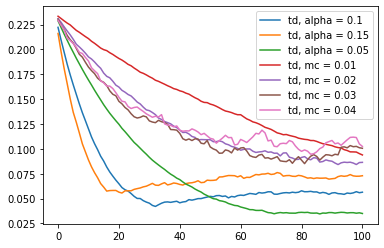

In [94]:
for alpha,error in rmse.items():
    plt.plot(error,label = 'td, alpha = '+str(alpha))
for alpha,error in rmse_mc.items():
    plt.plot(error,label = 'td, mc = '+str(alpha))
plt.legend()

# Q7 Q-Learning vs Sarsa 

In [47]:
ROWS = 4
COLS = 12
EPSILON = .1
REWARD = -1
REWARD_CLIFF = -100
EPS = 500
RUNS = 200
ALPHA = .1
START = (3,0)
TERMINAL = (3,11)

In [48]:
def is_cliff(x,y):
    if(x==3 and y>=1 and y<=COLS-2):
        return True
    return False

In [49]:
def eps_greedy(state):
    num = np.random.uniform(0,1)
    if(num>.1): #greedy action
        action = np.argmax(q[state[0]][state[1]])
    else:   #Explore
        action = np.random.randint(0,4)
    return action

In [50]:
def step(state,action):
    x,y = state
    if(action==0):
        x-=1
    elif(action==1):
        x+=1
    elif(action==2):
        y-=1
    else:
        y+=1
    if(x<0 or y<0 or x >= ROWS or y>=COLS):
        return state,-1
    elif(is_cliff(x,y)):
        return START,-100
    else:
        return (x,y),-1

In [51]:
def sarsa():
    rewards = np.zeros(EPS)
    for ep in range(EPS):
        state = START
        action = eps_greedy(state)
        total = 0
        while(1):
            next_state,reward = step(state,action)
            next_action = eps_greedy(next_state)
            x,y = state
            q[x][y][action] += ALPHA*(reward + q[next_state[0]][next_state[1]][next_action] - q[x][y][action])
            state = next_state
            action = next_action
            total+=reward
            if(next_state==TERMINAL):
                break
        total = max(total,-100)
        rewards[ep] = total
    return rewards

In [52]:
def q_learning():
    rewards = np.zeros(EPS)
    for ep in range(EPS):
        total = 0
        state = START
        while(1):
            action = eps_greedy(state)
            next_state,reward = step(state,action)
            x,y = state
            nextval = np.max(q[next_state[0]][next_state[1]])
            q[x][y][action] += ALPHA*(reward + nextval - q[x][y][action])
            state = next_state
            total+=reward
            if(next_state==TERMINAL):
                break
        total = max(total,-100)
        rewards[ep] = total
    return rewards

In [53]:
q = np.zeros((ROWS,COLS,4))

sarsa_rewards = np.zeros(EPS)
qlearning_rewards = np.zeros(EPS)
for r in tqdm(range(RUNS)):
    rewards = sarsa()
    sarsa_rewards += rewards
    q = np.zeros((ROWS,COLS,4))
    rewards = q_learning()
    qlearning_rewards += rewards
    q = np.zeros((ROWS,COLS,4))
sarsa_rewards = sarsa_rewards/RUNS
qlearning_rewards = qlearning_rewards/RUNS

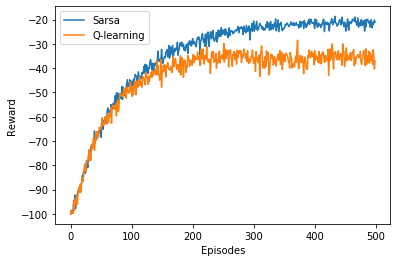

In [54]:
plt.plot(sarsa_rewards,label = 'Sarsa')
plt.plot(qlearning_rewards, label = 'Q-learning')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.legend()